# 

# Energy-Based Models (EBM)

Diffusion model is energy based, so let's start from energy-based models.

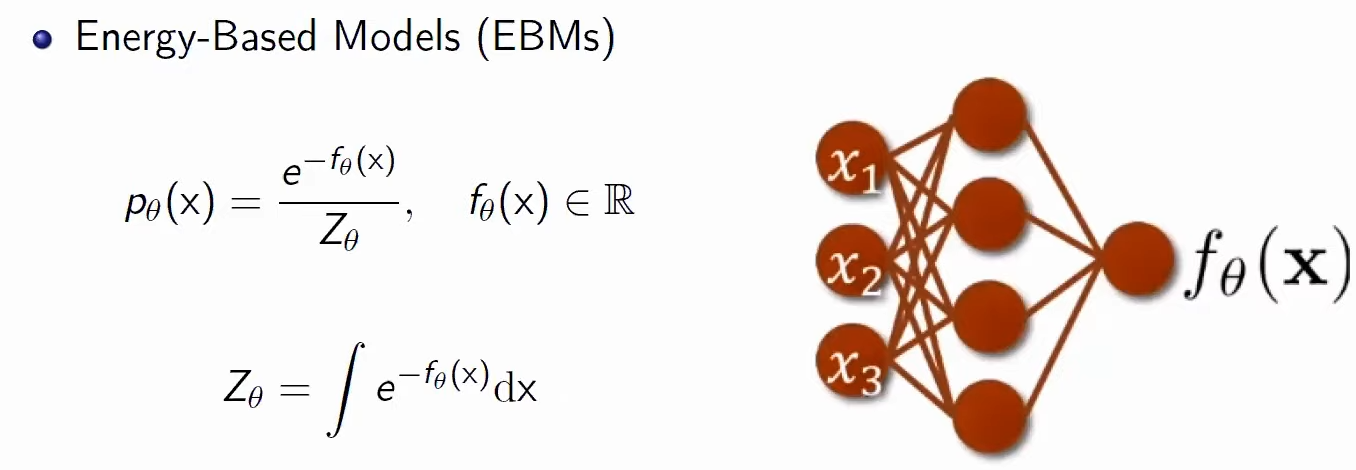

f<sub>θ</sub>(x) - potential energy function (range from -inf to +inf) of object x. Potential energy tells us about probability of sampling object x from distribution (high potential energy - low probability and vise versa). Example of potential energy function implementation - some neural net.

p<sub>θ</sub>(x) - probability density

Z<sub>θ</sub> - normalization constant, is used to make p<sub>θ</sub>(x) vary from 0 to 1.

Advantages of energy base models:

- it's simple and fast if it's already trained

Disadvantages of energy base models:

- training is a real problem, because if we want to train through MLE, we need to evaluate this:

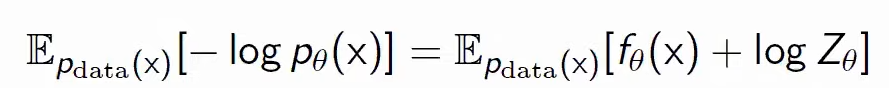

We know how to calculate first term, but calculation of the second term (log(Z<sub>θ</sub>)) is very-very expensive.

How to solve this?

## Score matching

Let score function be

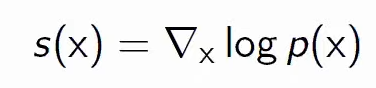

Score function for EBM

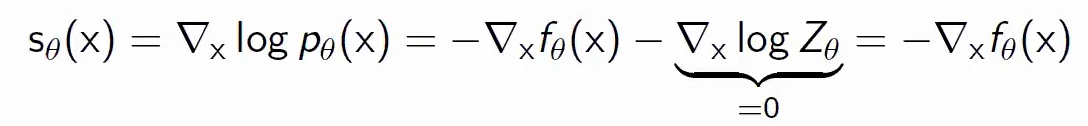

Gradient of Z<sub>θ</sub> if 0 because Z<sub>θ</sub> is a constant.

## Main idea

So instead of maximizing of likelihood let's mimize difference between the real score function and score function of our model.

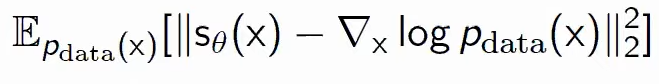

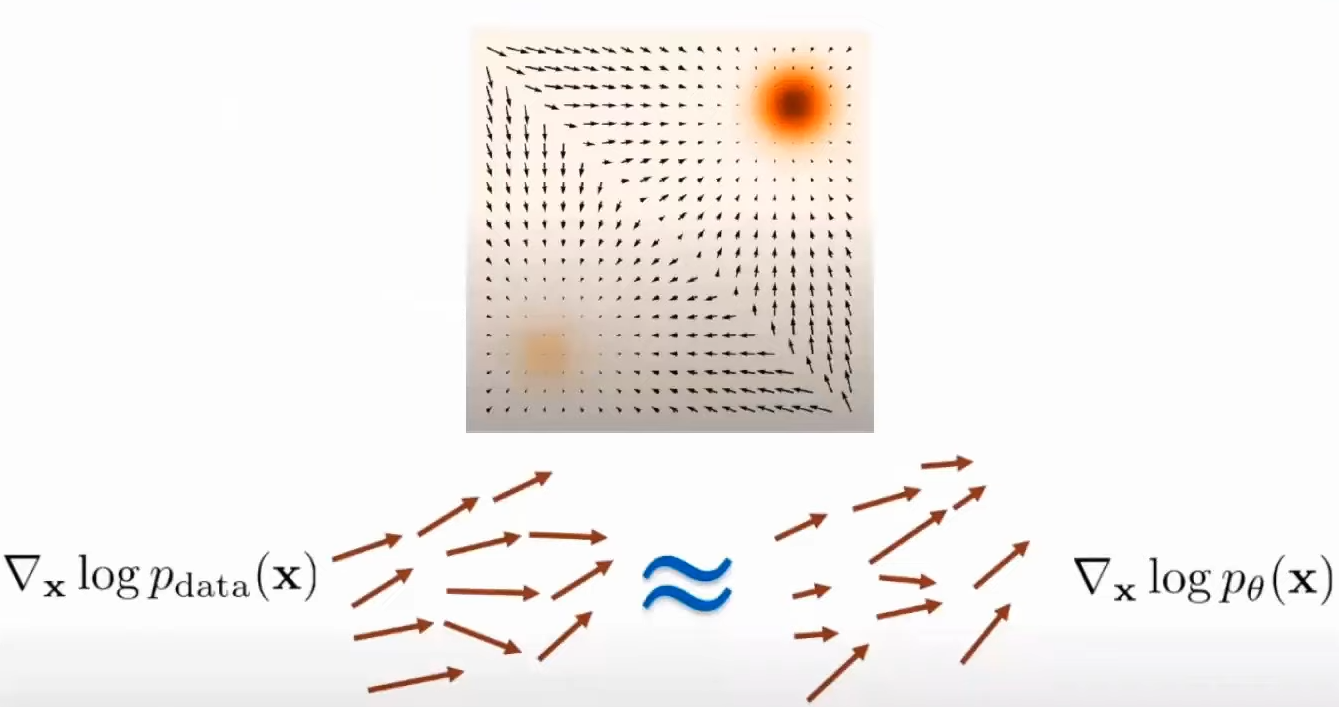

But we don't know how to calculate the real score function (p<sub>data</sub>). We have access only to some samples of the dataset. How to convert them to distribution? The answer is **Denoising score matching** and **Sliced score matching**.

## Train score matching: Denoising score matching

Main idea: let's just noise our data, so we can generate as match data as we want with noising and this will help to turn our discreete data to continous distribution.

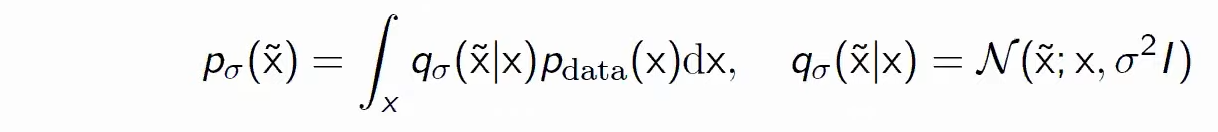

Score matching for noised data

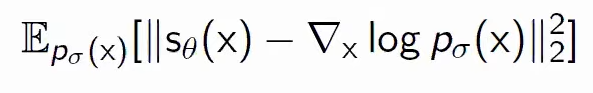

Can be rewrited as

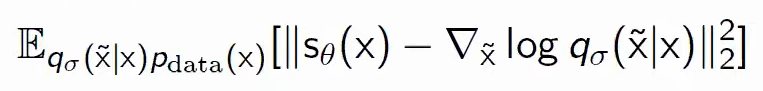

## Train score matching: Sliced score matching

Main idea: rewrite score matching to be able to access p<sub>data</sub>

Multidimensional case:

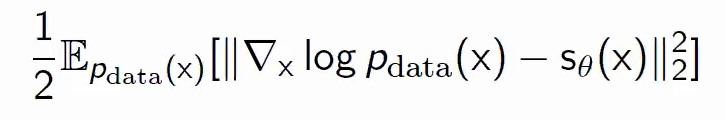

Let's derive Sliced score matching for 1-dimension case

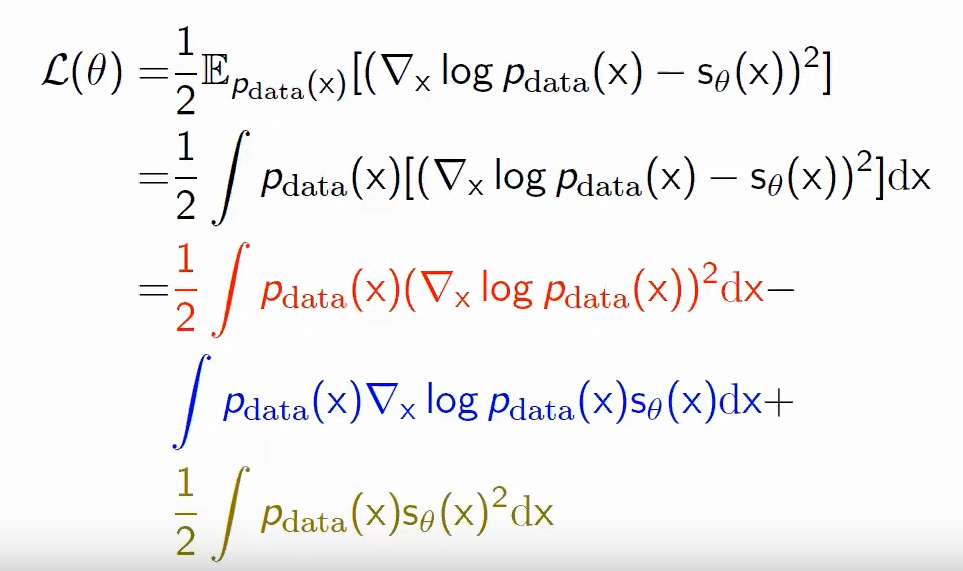

First term doesn't depend on θ (so we ignore him), third term is easy to evaluate.

Let's consider second term:

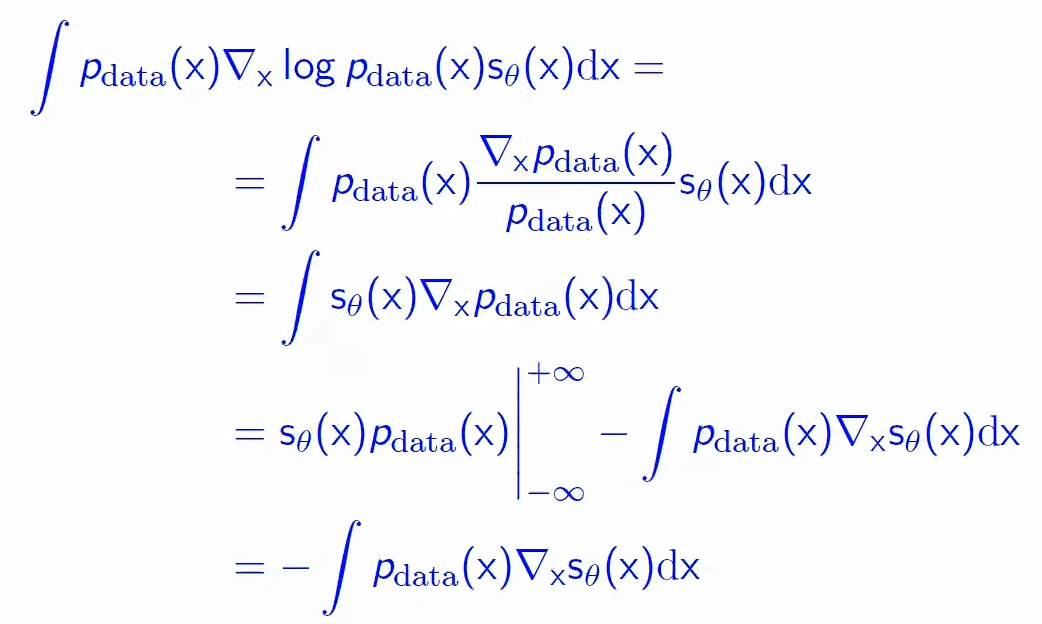

First term in result is equal to zero because we suppose that probability density -> 0 for x -> -inf or +inf. So only second term is left.

Now let's join together again second and third terms:

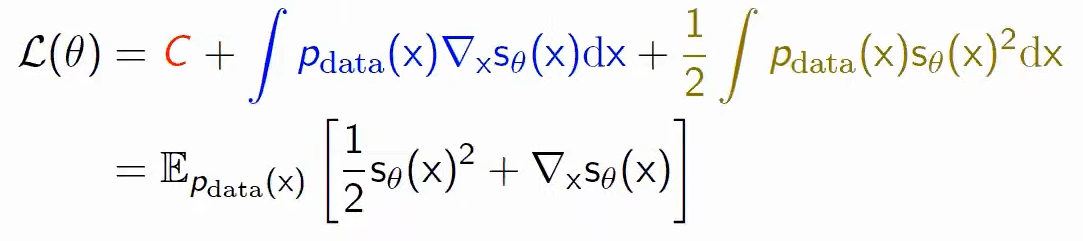

For multidimensional case:

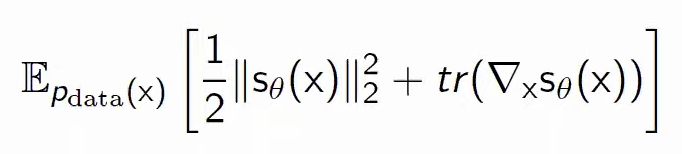

Now with this formula we don't need access to the real score function

But this formula will be calculated for too long because if s<sub>θ</sub> is some neural net - we need to do O(D) backpropagations of s<sub>θ</sub> to calculate trace (D - the number of dimensions).

### Sliced score matching: Hutchinson trace estimator

Helps to speed-up trace calculation:

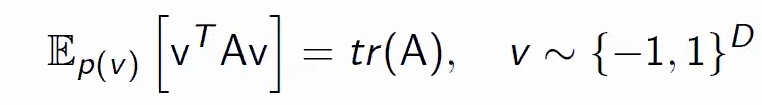

This works because diagonal elements of matrix are twice multiplied on the same element of v (-1 or 1) and any else element with equal probability (0.5) will be multiplied by -1 or 1. So the expectation for A<sub>ii</sub> will be A<sub>ii</sub> and expectation for A<sub>ij</sub> = - 0.5 * A<sub>ij</sub> + 0.5 * A<sub>ij</sub> = 0.

So score matching formula can be rewritten as

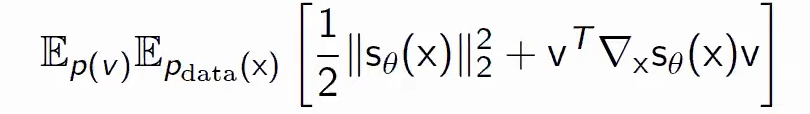

And with **Vector Jacobian Product (VJP)** we can calculate backpropagation with O(1) complexity

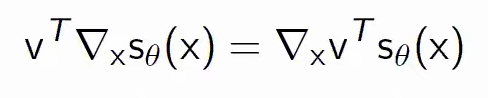

Main idea of VJP: multiply vector output of function s<sub>θ</sub> (or any other function) on v<sup>T</sup> and get one number instead of vector. This lets us make one backpropagation instead of making multiple backpropagations for every element of vector. 

## Score matching: data sampling

We need to be sure that our data is sampled from the real distribution

Use **Langevin dynamics**

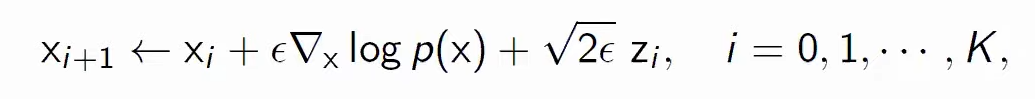

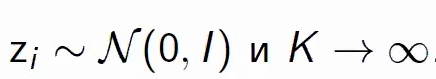

If ε is small enough and K -> inf: X<sub>K</sub> is sampled from the real distribution

## Score matching: pipeline

1. Set model
    - set as EBM and evaluate score function

    or
    
    - set score function
2. Train score matching
    - denoising score matching

    or
    
    - sliced score matching
3. Sample with Langevin dynamics

But if we use it as it is, we will get this

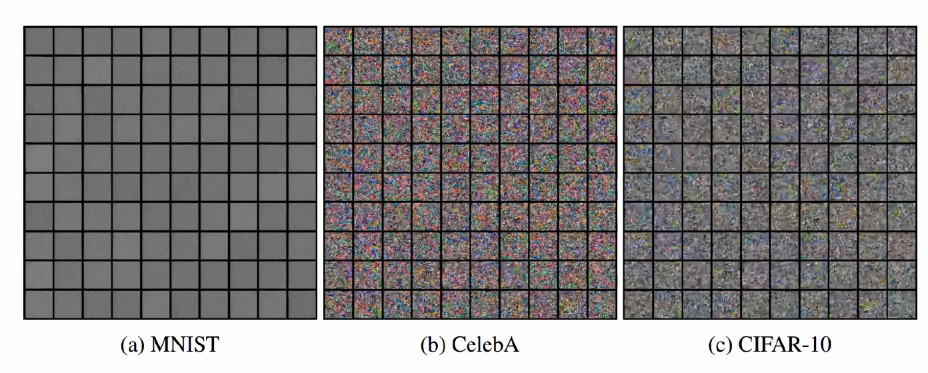

But why?

## Score matching: problems

1. We know nothing about regions where there is no data.  

    Usual structure of data is couple of modes and nothing between them. Gradients in the places between modes can be arbitrary and function can return any result.

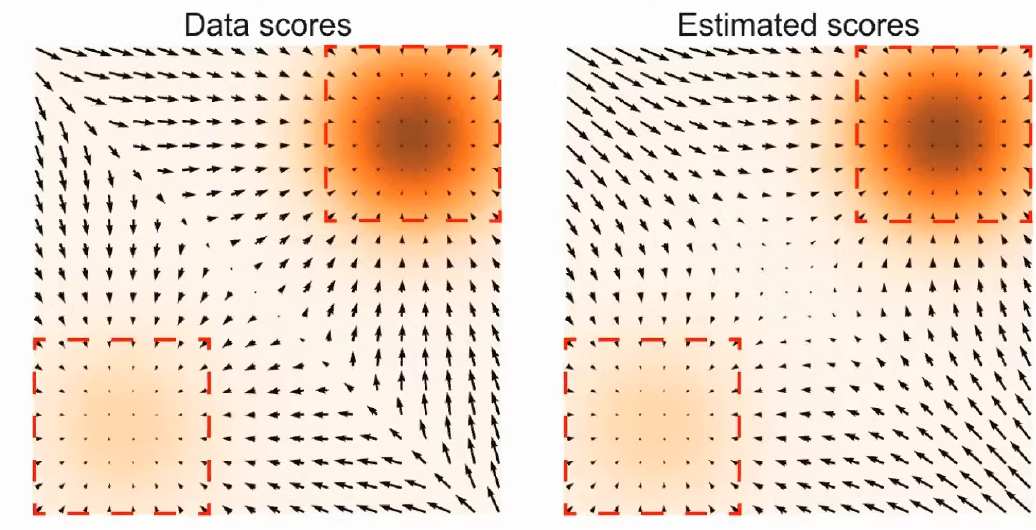

2. Score matching train is unstable (left).

    Reason is similar to the first point (dimensiality of data is much lower than dimesiality of space which contains that data -> model learns very narrow distributions and small change of data leads to a huge loss). Adding of noise stabilizes the training (right) because this operation increases dimensiality of data.

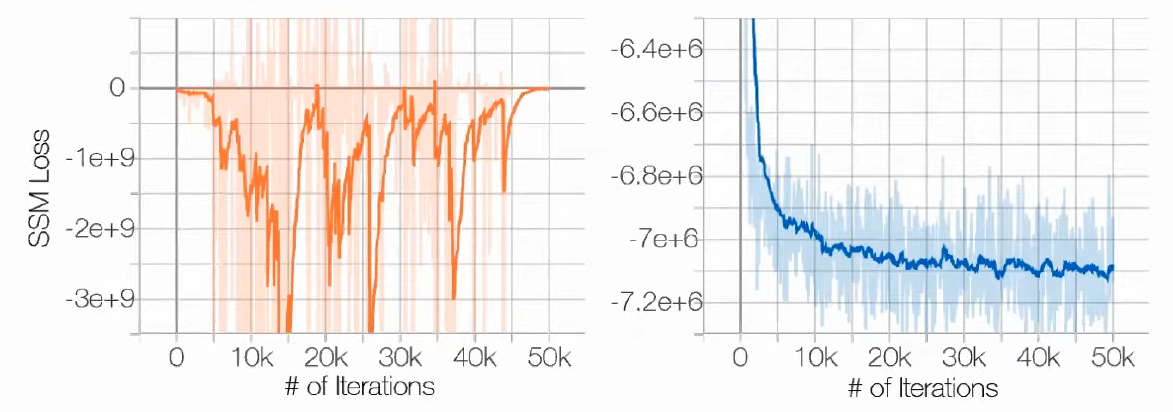

3. Langevin dynamics can't move between modes when there are no data

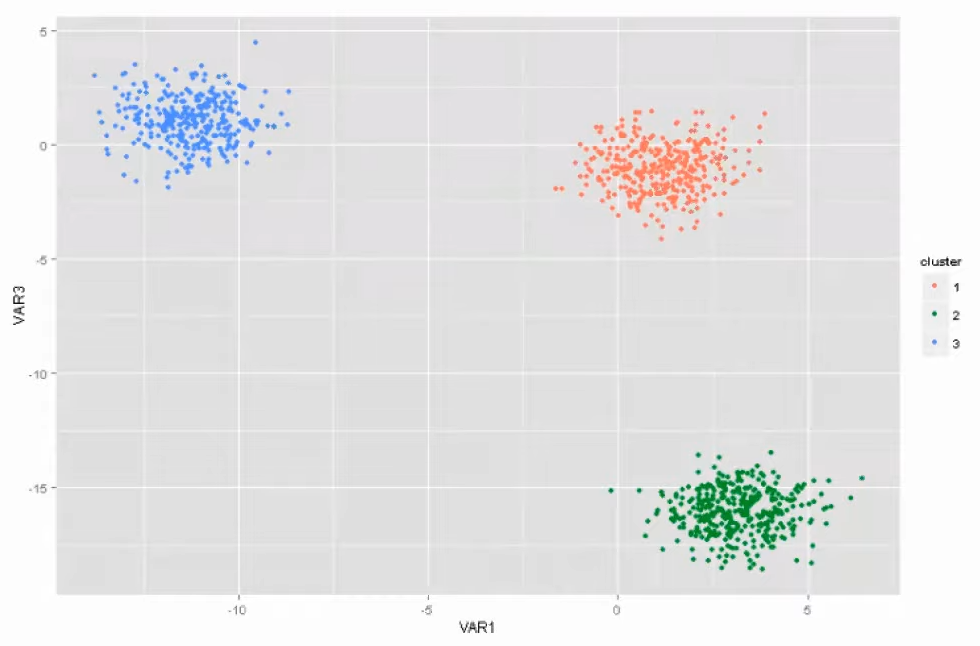

All of this problem can be solved with data noising. But with huge noising that won't be the data that we want and not the same distribution that we want. So we have a tradeoff: huge noising stabilizes the training and helps to merge the modes with each other but it changes the data and distribution.

Solution is **multilevel noising**.

## Score matching: multilevel noising

Main idea: add noise gradually by levels. On each level noise amount is increased. θ is trained to evaluate score function s<sub>θ</sub> for any σ<sub>i</sub>.

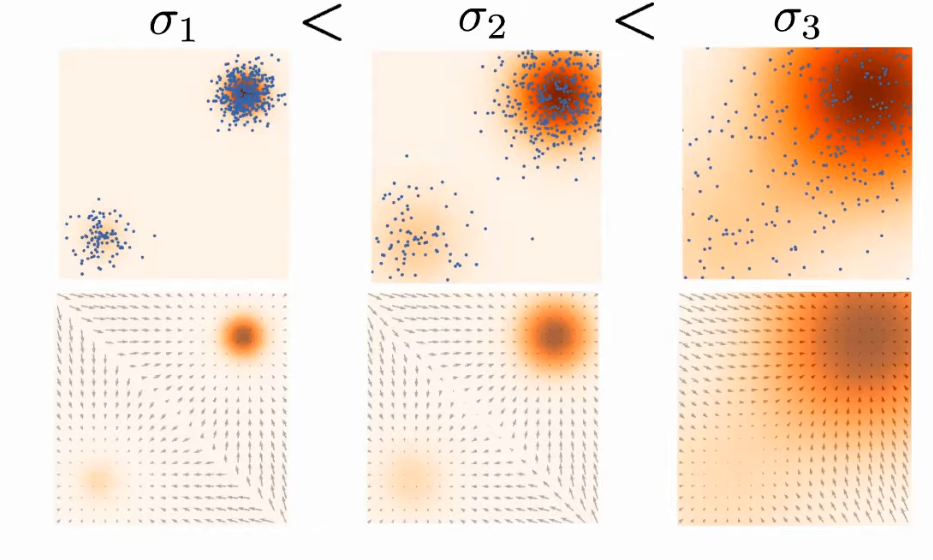

**How to do it?**

Make score function for each level

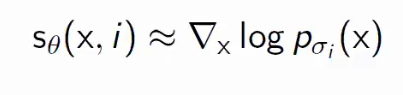

And train multilevel score matching

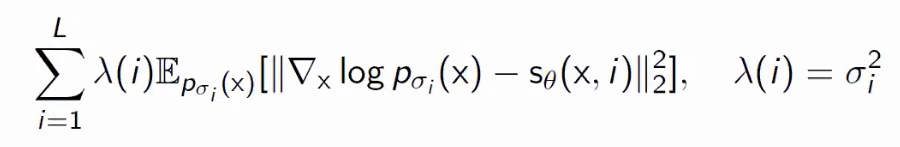

## Diffusion Model with Multilevel Noising: Noise Condition Score Network (NCSN)

For each noise level (L levels total) algorithm makes T samples using Langevin dynamics. Authors used L=10 and T=100.

Maybe on line 2 there is a mistake: must be i <- L to 1 and this makes α decrease with level number increase.

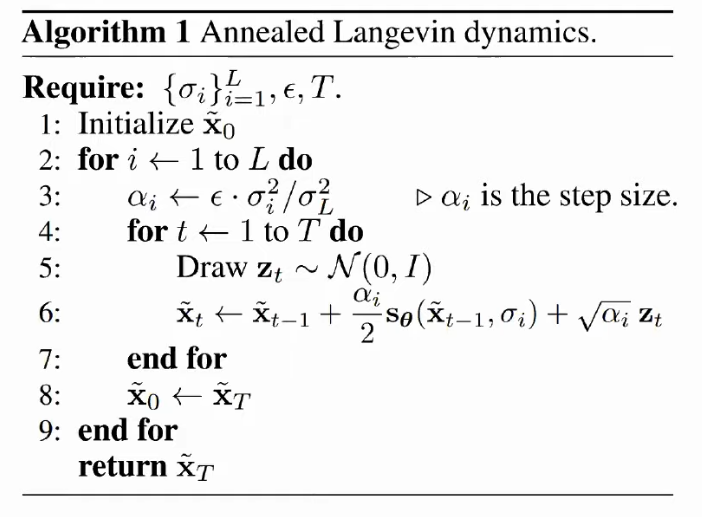

## NCSN: result

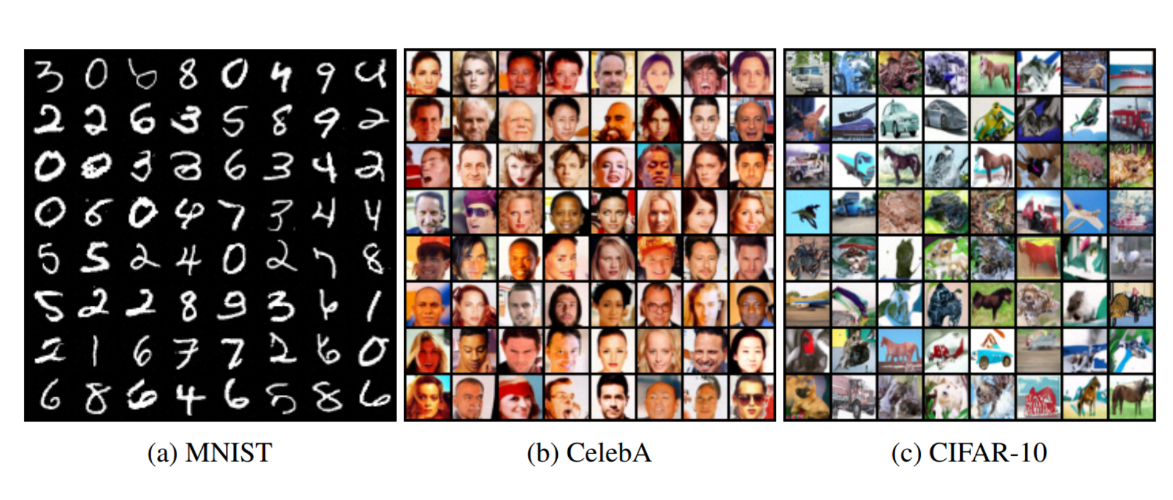

# Denoising Diffusion Probabilistic Model (DDPM)

Main idea: gradually add noise to image and train model to denoise image.

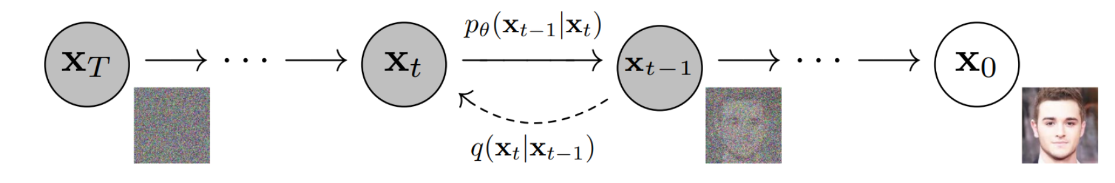

## DDPM: data noising

Noising process is a Markov's Chain. p is a probability of x<sub>t-1</sub> moving to x<sub>t</sub> through noising process, p is a probability of opposite denoising process. β<sub>t</sub> - some coefficients that grow from 1e-4 to 1e-2 with t increasing. That eventually leads to signal level decreasing and noise level increasing. β<sub>t</sub> coefficient values are selected in such a way that only noise remains in the end and that noise is normally distributed.

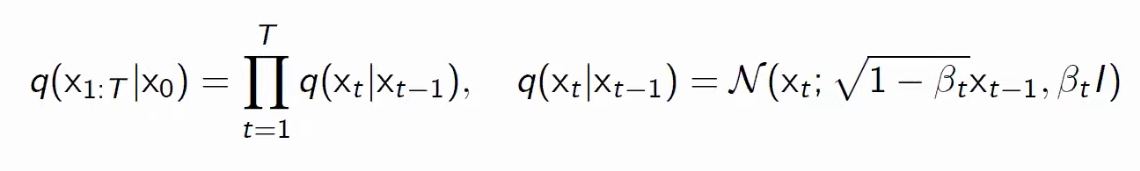

Multistep noising

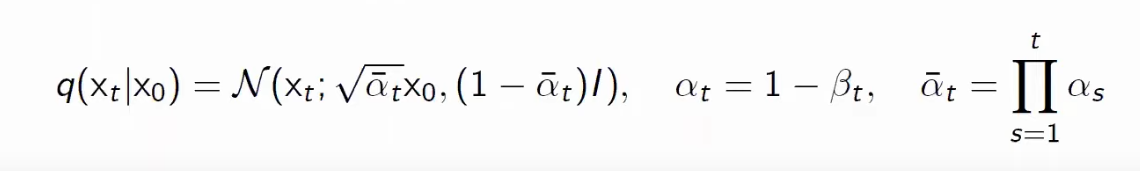

## DDPM: data denoising

In the begining of formula there is a mistake: must be p<sub>θ</sub>(x<sub>0:T</sub>) 

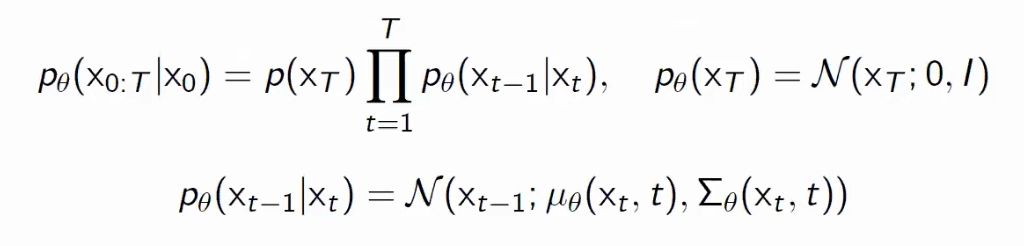

### Data denoising: how to train θ?

Let's train it with MLE

At first let's write what p<sub>θ</sub>(x<sub>0) is:

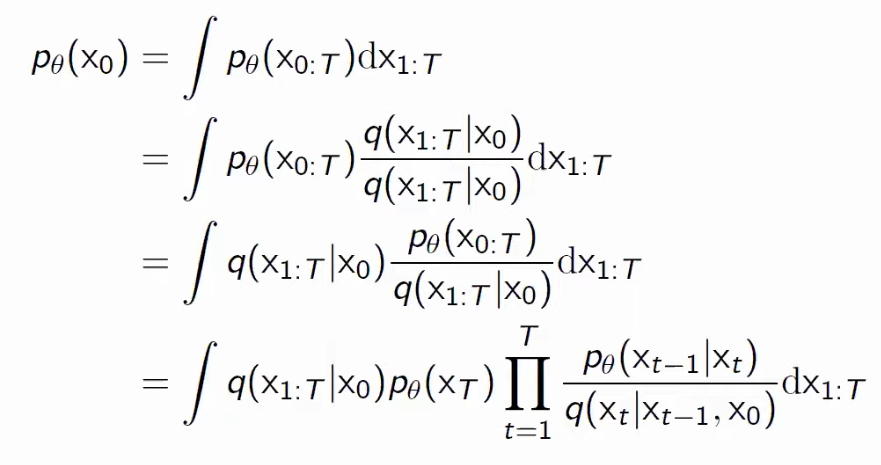

During inference we used the fact that

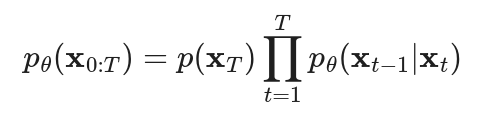

You can prove it if use Bayes formula to transform p<sub>θ</sub>(x<sub>t-1</sub>|x<sub>t</sub>) to p<sub>θ</sub>(x<sub>t</sub>|x<sub>t-1</sub>) * p<sub>θ</sub>(x<sub>t-1</sub>) / p<sub>θ</sub>(x<sub>t</sub>) and calculate production of these terms from 1 to T.

### Data denoising: MLE formula

1. Paste p<sub>θ</sub>(x<sub>0</sub>) into the formula. 
2. Calculate Evidence Lower Bound (ELBO) for it. 
3. Now we can join two integrals of q(x<sub>0</sub>) and q(x<sub>1:T</sub>|x<sub>0</sub>) to integral of q(x<sub>0:T</sub>). 
4. Convert log of production to sum of logarithms.

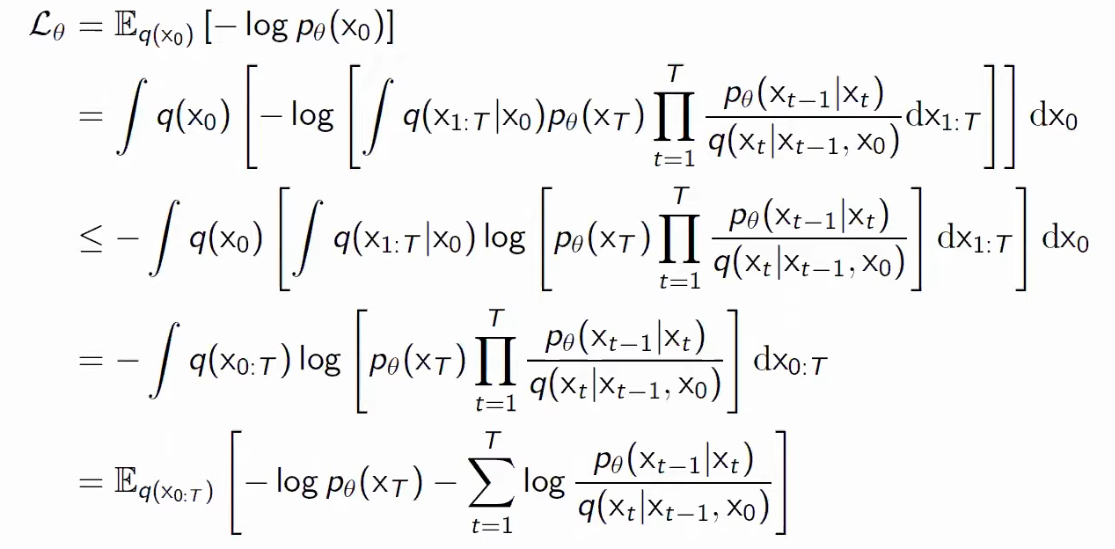

5. Rewrite formula with separate sum term (mistake in formula: q(x<sub>1</sub>|x<sub>0</sub>, x<sub>0</sub>) instead of q(x<sub>t</sub>|x<sub>1</sub>, x<sub>0</sub>))
6. Use Bayes formula to translate 1 / q(x<sub>t</sub>|x<sub>t-1</sub>, x<sub>0</sub>) to q(x<sub>t-1</sub> | x<sub>0</sub>) / (q(x<sub>t-1</sub>|x<sub>t</sub>, x<sub>0</sub>) * q(x<sub>t</sub> | x<sub>0</sub>)) (in denominaotor), there is also mistake in formula on image
7. If we calculate production of q(x<sub>t-1</sub> | x<sub>0</sub>) / q(x<sub>t-1</sub>|x<sub>t</sub>, x<sub>0</sub>) for t in 1 to T we will get 1/q(x<sub>T</sub> | x<sub>0</sub>) (adjucent terms destroy each other), and if we do the same for the last term we will also get q(x<sub>T</sub> | x<sub>0</sub>) in denominator. Let's put this term off the brackets.
8. And if we look at the result we will see that first and second terms are KL-divergences.

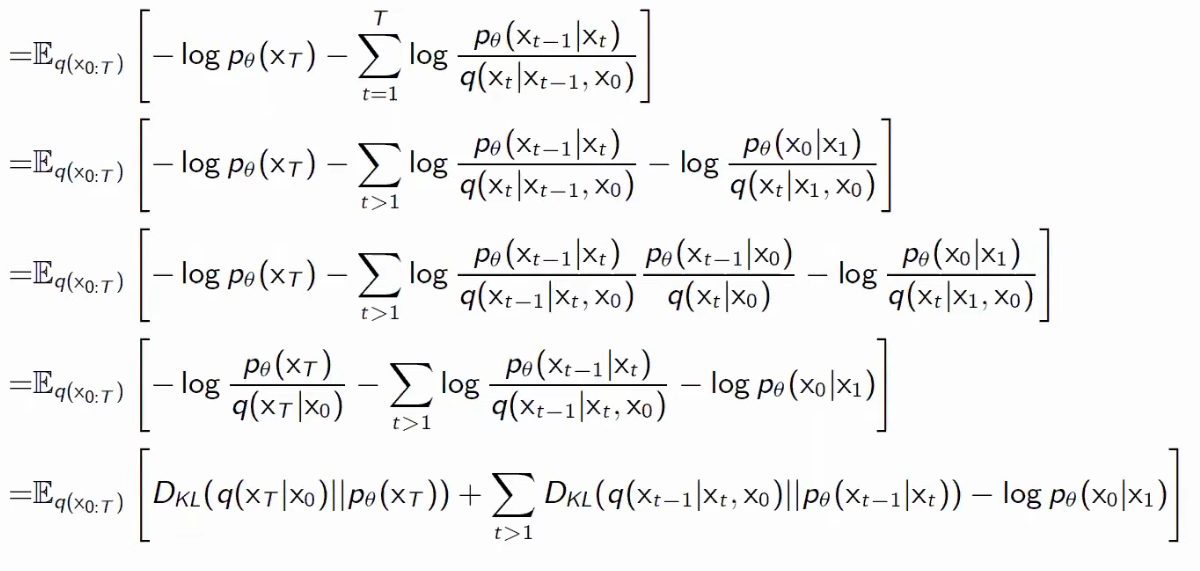

9. First and third terms are constansts, let's see on the second term. q(x<sub>t-1</sub> | x<sub>t</sub>, x<sub>0</sub>) has Gaussian distribution. Parameters μ<sub>t</sub> and β<sub>t</sub> can be found because we know distribution of q on each step.

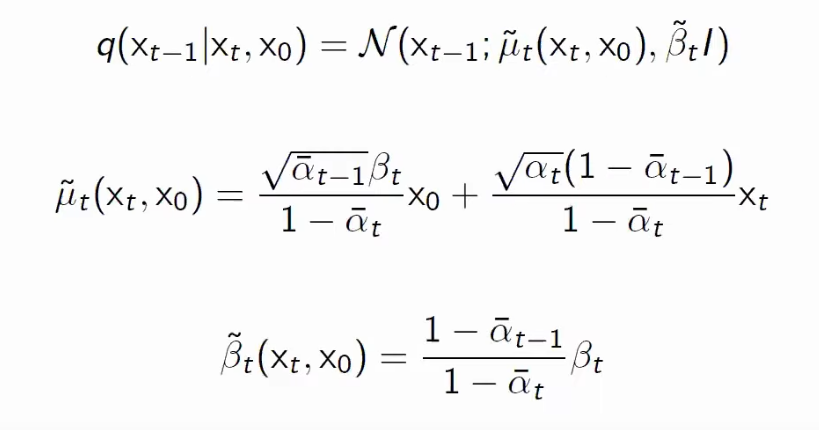

10. Now let's calculate KL-divergence between p and q. Both of them has Gaussian distribution + we make covariate matrices of p and q equal to simplify KL-divergence calculation. Then KL-divergence (and our loss function) for step t-1 will be:

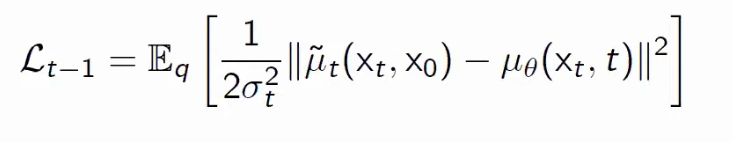

11. Formula on step 10 is our objective. We are already can train model from this step. But we can additionally simplify the calculation by parametrizing μ<sub>θ</sub> to make it similar to μ<sub>t</sub>. To do that let's set x<sub>0</sub> as

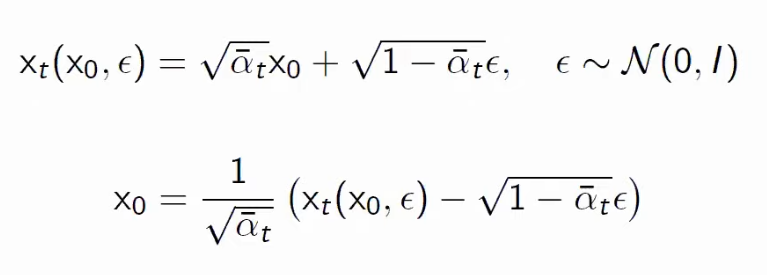

12. Then rewrite KL-divergence for step t-1:

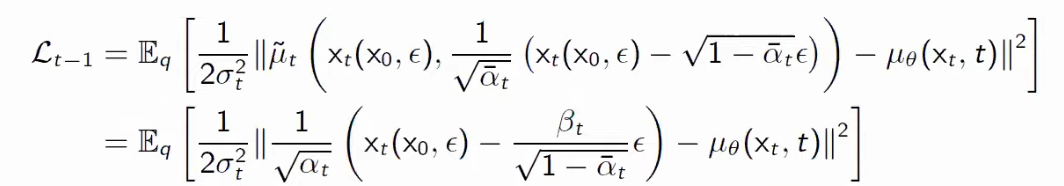

13. Let's build μ<sub>θ</sub> via the same formula as μ<sub>t</sub> and parametrize it with some paramter ε<sub>θ</sub>:

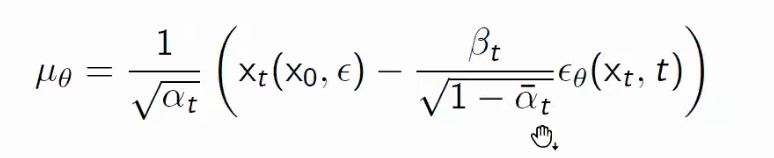

14. And now KL-divergence for step t-1 will be:

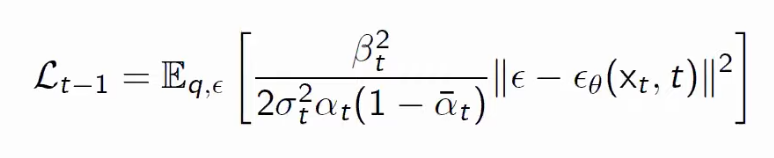

Where ε<sub>θ</sub> is some NN that takes x<sub>t</sub> and t as inputs and learns objective L<sub>t-1</sub>. Authors tried to learn model via formula from step 10 and via formula from step 14 and the last formula gives better results.